<img src="https://upload.wikimedia.org/wikipedia/en/8/85/PFF-Logo-White-1_reduced.png" />

# Expected Points Added Model

### Project Description

This notebook contains the work for our STAT 4800, Advanced Sports Analytics, Final Project. We were tasked with building an Expected Points Added Model. Given an initial start state, specifically the down, yards to go, and field position, our model simulates drives in order to calculate the expected next score.  

We used [Pro Football Focus](https://www.pff.com/) data from 2015 to 2019 to build our model.

## Table of Contents <a class="anchor" id="toc"></a>

* **[0. Import Libraries](#import)**
* **[1. Load Data](#load)**
* **[2. Feature Selection and Engineering](#fse)**
    * [2.1 Remove Garbage Time](#garbage)
    * [2.2 Create Custom Field Position](#fp)
* **[3. Transform Data for Modeling](#transform)**
    * [3.1 Subset and Clean Run/Pass Data](#rp)
    * [3.2 Subset and Clean Field Goal Data](#sub_fg)
* **[4. Field Goal Model](#fg)**
    * [4.1 Threshold Experimentation](#threshold)
    * [4.2 Final Logistic Regression Model](#log)
* **[5. Punt Model](#punt)**
* **[6. Run Models](#run)**
    * [6.1 Quantile Cut by Yards to Go](#cut)
    * [6.2 Guassian Mixture Models](#mixture)
* **[7. Pass Models](#pass)**
    * [7.1 Quantile Cut by Yards to Go](#cut2)
    * [7.2 Guassian Mixture Models](#mixture2)
* **[8. Expected Points Added Model](#epa)**
* **[9. Data Visualization](#viz)**
    * [9.1 Calculate EPA for Start State Grid](#grid)
    * [9.2 Plotly EPA Bar Chart](#plotly)
    * [9.3 Football Field Graphic (Future Use)](#field)
* **[10. References](#ref)** 
* **[11. Authors](#authors)**

### 0. Import Libraries <a class="anchor" id="import"></a>

[Table of Contents](#toc)

In [25]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [26]:
from pandas.core.common import SettingWithCopyWarning
import warnings

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [27]:
SEED = 42

### 1.0 Load Data <a class="anchor" id="load"></a>

[Table of Contents](#toc)

*Aggregate Data across Years; modify ROOT directory to run locally...*

In [28]:
ROOT = '/Users/iainmuir/Desktop/4Y 1S/STAT 4800/Dataset/{} PFF All Plays.csv'

In [29]:
DATA = pd.DataFrame()

In [30]:
%%time

for year in range(2015, 2020):
    PATH = ROOT.format(year)
    df = pd.read_csv(PATH, low_memory=False)
    DATA = pd.concat([DATA, df])

CPU times: user 46.2 s, sys: 13.4 s, total: 59.6 s
Wall time: 1min 12s


In [31]:
DATA.shape

(758971, 177)

In [32]:
DATA.head()

,pff_PLAYID,pff_GAMEID,pff_GAMEDATE,pff_GAMESEASON,pff_WEEK,pff_GSISGAMEKEY,pff_GSISPLAYID,pff_QUARTER,pff_DOWN,pff_CLOCK,...,pff_STSAFETIES,pff_TACKLE,pff_TACKLEASSIST,pff_TEALIGNMENT,pff_TOUCHDOWN,pff_UNBLOCKEDPRESSURE,pff_VISE,pff_WRALIGNMENT,pff_PLAYCLOCK,pff_RUNPASSOPTION
0,1455513,5573,12/31/15,2015,PO,60761,35,1,0,15:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1455434,5573,12/31/15,2015,PO,60761,49,1,1,15:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LWR^; SRiWR; SRoWR^; RWR,NaN,0.0
2,1455470,5573,12/31/15,2015,PO,60761,68,1,2,14:33,...,NaN,SCCL D15,NaN,NaN,NaN,NaN,NaN,LWR^; SRiWR; SRoWR^; RWR,NaN,0.0
3,1455450,5573,12/31/15,2015,PO,60761,90,1,3,14:03,...,NaN,SCCL D18,NaN,NaN,NaN,NaN,NaN,LWR; SLWR^; SRWR^; RWR,NaN,0.0
4,1455419,5573,12/31/15,2015,PO,60761,112,1,1,13:51,...,NaN,SCCL D91,NaN,NaN,NaN,NaN,NaN,LWR; SLWR^; SRWR^; RWR,NaN,0.0


In [186]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758971 entries, 0 to 167026
Columns: 177 entries, pff_PLAYID to pff_RUNPASSOPTION
dtypes: float64(30), int64(30), object(117)
memory usage: 1.0+ GB


In [187]:
d = DATA.copy()

### 2.0 Feature Selection and Engineering <a class="anchor" id="fse"></a>

[Table of Contents](#toc)

#### 2.1 Remove Garbage Time <a class="anchor" id="garbage"></a>

In [188]:
d = d.loc[d['pff_GARBAGETIME'] == 0]

In [189]:
d = d.reset_index(drop=True)

In [190]:
d.shape

(721010, 177)

#### 2.2 Custom Field Position <a class="anchor" id="fp"></a>

In [191]:
fp = d['pff_FIELDPOSITION']
d['fp'] = np.where(fp < 0, -1 * fp, 100 - fp)

In [192]:
len(d['fp'].unique())

99

### 3.0 Transform All Data <a class="anchor" id="transform"></a>

[Table of Contents](#toc)

#### 3.1 Subset Run and Pass Data Sets <a class="anchor" id="rp"></a>

In [193]:
PLAYS = d.loc[(d['pff_RUNPASS'] == 'P') | (d['pff_RUNPASS'] == 'R')]

In [194]:
PLAYS.shape

(578355, 178)

In [195]:
INPUTS = [
    'pff_DOWN', 'pff_DISTANCE', 'pff_GAINLOSSNET', 'pff_PASSRESULT', 'fp', 'pff_RUNPASS'
]

In [196]:
plays = PLAYS[INPUTS]

In [197]:
plays.head()

,pff_DOWN,pff_DISTANCE,pff_GAINLOSSNET,pff_PASSRESULT,fp,pff_RUNPASS
1,1,10,-6,SACK,25,P
2,2,16,9,NaN,19,R
3,3,7,17,NaN,28,R
4,1,10,1,NaN,45,R
5,1,10,15,INCOMPLETE,46,P


In [198]:
plays.shape

(578355, 6)

In [199]:
plays.isnull().sum()

pff_DOWN                0
pff_DISTANCE            0
pff_GAINLOSSNET         0
pff_PASSRESULT     274374
fp                      0
pff_RUNPASS             0
dtype: int64

In [200]:
plays['pff_PASSRESULT'] = plays['pff_PASSRESULT'].fillna('RUN')

In [201]:
plays.isnull().sum().sum()

0

In [202]:
RUN = plays.loc[plays['pff_RUNPASS'] == 'R']
PASS = plays.loc[plays['pff_RUNPASS'] == 'P']

In [203]:
print("Run:", RUN.shape)
print("Pass:", PASS.shape)

Run: (274368, 6)
Pass: (303987, 6)


#### 3.2 Subset Field Goals Data <a class="anchor" id="sub_fg"></a>

In [204]:
FGS = d.loc[d['pff_SPECIALTEAMSTYPE'].astype(str) == 'FIELD GOAL']

In [205]:
FGS.shape

(12548, 178)

In [206]:
FGS[['kickResult', 'kickLocation']] = FGS['pff_KICKRESULT'].str.split(' - ', expand=True)
FGS['kickResult'] = np.where(FGS['kickResult'] == 'MISSED', 0, 1)

In [207]:
INPUTS = [
    'pff_HASH', 'pff_KICKYARDS', 'kickResult'
]

In [208]:
model_fg = FGS[INPUTS]

In [209]:
model_fg.shape

(12548, 3)

In [210]:
model_fg = model_fg.dropna()

In [211]:
model_fg.shape

(12535, 3)

In [212]:
TARGET = 'kickResult'
X_fg = model_fg.drop(TARGET, axis=1)
y_fg = model_fg[TARGET]

In [213]:
hash_, yards = X_fg['pff_HASH'], X_fg['pff_KICKYARDS']
hash_ = np.array(hash_).reshape(-1, 1)
one_hot = OneHotEncoder(sparse=True).fit_transform(hash_).toarray()
hash_ = pd.DataFrame(one_hot, columns=['hash_C', 'hash_L', 'hash_R'])
X_prep_fg = hash_.join(yards.reset_index(drop=True).astype(int))

In [214]:
X_prep_fg.head()

,hash_C,hash_L,hash_R,pff_KICKYARDS
0,0.0,1.0,0.0,26
1,0.0,0.0,1.0,36
2,0.0,0.0,1.0,22
3,0.0,1.0,0.0,43
4,0.0,0.0,1.0,47


### 4.0 Field Goal Model <a class="anchor" id="fg"></a>

[Table of Contents](#toc)

#### 4.1 Threshold Experimentation <a class="anchor" id="threshold"></a>

In [215]:
def metrics(model, x, y, threshold=0.5):
    """
    @param model — fitted Logistic Regression Model
    @param x – x test for prediction
    @param y – y yest for comparison
    @param threshold – percent at which to classify the positive class
    
    Outputs Confusion Matrix and F1-Score for a fitted Logistic Regression Model
        Used for experimenting with best threshold for classification
    """
    y_prob = model.predict_proba(x)[:, 1]
    predictions = np.where(y_prob > threshold, 1, 0)
    print("\nConfusion Matrix (t={})".format(threshold))
    print(confusion_matrix(y, predictions))
    f1_ = f1_score(y, predictions)
    print("F1:", f1_)

    return f1_

In [216]:
def log_reg(X, y, threshold=0.5):
    """
    @param X – Input features (Hash/Distance)
    @param y – Output feature (Make/Miss)
    @param threshold – percent at which to classify the positive class
    
    Initialize and fit a Logistic Regression Model given Field Goal data
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2
    )

    lr = LogisticRegression(
        solver='lbfgs'
    )
    lr = lr.fit(X_train, y_train)
    f1_score = metrics(lr, X_test, y_test, threshold)

    return lr, f1_score

In [217]:
thresholds = np.arange(0.5, 1.05, 0.05)
f1_scores = []

for t in thresholds:
    model, f1 = log_reg(X_prep_fg, y_fg, round(t, 2))
    f1_scores.append(f1)


Confusion Matrix (t=0.5)
[[ 136  505]
 [ 110 1756]]
F1: 0.8509813423794523

Confusion Matrix (t=0.55)
[[ 198  460]
 [ 213 1636]]
F1: 0.829404309252218

Confusion Matrix (t=0.6)
[[ 264  390]
 [ 277 1576]]
F1: 0.8253469494632103

Confusion Matrix (t=0.65)
[[ 338  296]
 [ 403 1470]]
F1: 0.8079142621599341

Confusion Matrix (t=0.7)
[[ 412  251]
 [ 535 1309]]
F1: 0.7690951821386605

Confusion Matrix (t=0.75)
[[ 468  202]
 [ 740 1097]]
F1: 0.6996173469387754

Confusion Matrix (t=0.8)
[[526 133]
 [915 933]]
F1: 0.6403568977350721

Confusion Matrix (t=0.85)
[[ 617   83]
 [1148  659]]
F1: 0.5170655158885837

Confusion Matrix (t=0.9)
[[ 660   21]
 [1476  350]]
F1: 0.3186162949476559

Confusion Matrix (t=0.95)
[[ 688    1]
 [1817    1]]
F1: 0.001098901098901099

Confusion Matrix (t=1.0)
[[ 643    0]
 [1864    0]]
F1: 0.0


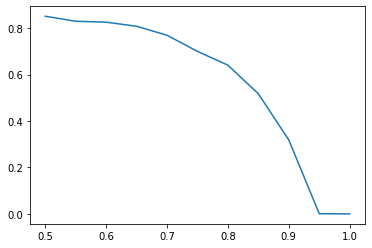

In [218]:
plt.plot(thresholds, f1_scores)
plt.show()

#### 4.2 Final Logistic Regression Model <a class="anchor" id="log"></a>

In [219]:
BEST_THRESHOLD = 0.6

In [220]:
fg_model, f1 = log_reg(X_prep_fg, y_fg, 0.6)


Confusion Matrix (t=0.6)
[[ 254  396]
 [ 252 1605]]
F1: 0.8320373250388803


### 5.0 Punt Distributions <a class="anchor" id="punt"></a>

[Table of Contents](#toc)

In [221]:
PUNTS = d.loc[d['pff_SPECIALTEAMSTYPE'] == 'PUNT'][['pff_KICKYARDS', 'pff_RETURNYARDS']]
PUNTS['pff_RETURNYARDS'] = PUNTS['pff_RETURNYARDS'].fillna(0)
PUNTS = PUNTS.dropna()

In [222]:
PUNTS.shape

(40782, 2)

In [223]:
PUNTS['NET_YARDS'] = PUNTS['pff_KICKYARDS'] - PUNTS['pff_RETURNYARDS']

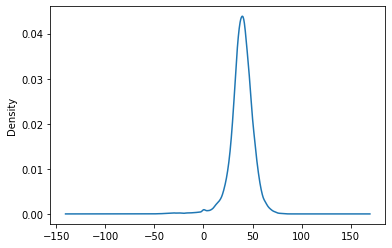

In [224]:
PUNTS['NET_YARDS'].plot.density()
plt.show()

In [225]:
x = np.array(PUNTS['NET_YARDS'])
punt_model = GaussianMixture(
        n_components=2,
).fit(x.reshape(-1, 1))

### 6.0 Run Models <a class="anchor" id="run"></a>

[Table of Contents](#toc)

In [226]:
run = RUN.drop('pff_PASSRESULT', axis=1)

In [227]:
r1 = run.loc[run['pff_DOWN'] == 1]
r2 = run.loc[run['pff_DOWN'] == 2]
r3 = run.loc[run['pff_DOWN'] == 3]
r4 = run.loc[run['pff_DOWN'] == 4]

In [228]:
print("Running Downs:")
print("\t1st:", r1.shape)
print("\t2nd:", r2.shape)
print("\t3rd:", r3.shape)
print("\t4th:", r4.shape)

Running Downs:
	1st: (141050, 5)
	2nd: (92323, 5)
	3rd: (34723, 5)
	4th: (5925, 5)


In [229]:
r4['pff_DISTANCE'].quantile(0.925)

5.0

#### 6.1 Quantile Cut by Yards to Go <a class="anchor" id="cut"></a>

In [230]:
r1['group'] = pd.qcut(r1['pff_DISTANCE'], q=[0, 0.05, 0.9675, 1], labels=['short', 'medium', 'long'])
r2['group'] = pd.qcut(r2['pff_DISTANCE'], q=[0, 0.25, 0.75, 1], labels=['short', 'medium', 'long'])
r3['group'] = pd.qcut(r3['pff_DISTANCE'], q=[0, 0.35, 0.75, 1], labels=['short', 'medium', 'long'])
r4['group'] = pd.qcut(r4['pff_DISTANCE'], q=[0, 0.7, 0.925, 1], labels=['short', 'medium', 'long'])

In [231]:
r1_s, r1_m, r1_l = r1.loc[r1['group'] == 'short'], r1.loc[r1['group'] == 'medium'], r1.loc[r1['group'] == 'long']
r2_s, r2_m, r2_l = r2.loc[r2['group'] == 'short'], r2.loc[r2['group'] == 'medium'], r2.loc[r2['group'] == 'long']
r3_s, r3_m, r3_l = r3.loc[r3['group'] == 'short'], r3.loc[r3['group'] == 'medium'], r3.loc[r3['group'] == 'long']
r4_s, r4_m, r4_l = r4.loc[r4['group'] == 'short'], r4.loc[r4['group'] == 'medium'], r4.loc[r4['group'] == 'long']

In [232]:
print("Running Categories:")
print("\t1st:", r1.shape)
print("\t\t1st Short:", r1_s.shape)
print("\t\t1st Medium:", r1_m.shape)
print("\t\t1st Long:", r1_l.shape)
print("\t2nd:", r2.shape)
print("\t\t2nd Short:", r2_s.shape)
print("\t\t2nd Medium:", r2_m.shape)
print("\t\t2nd Long:", r2_l.shape)
print("\t3rd:", r3.shape)
print("\t\t3rd Short:", r3_s.shape)
print("\t\t3rd Medium:", r3_m.shape)
print("\t\t3rd Long:", r3_l.shape)
print("\t4th:", r4.shape)
print("\t\t4th Short:", r4_s.shape)
print("\t\t4th Medium:", r4_m.shape)
print("\t\t4th Long:", r4_l.shape)

Running Categories:
	1st: (141050, 6)
		1st Short: (7336, 6)
		1st Medium: (129745, 6)
		1st Long: (3969, 6)
	2nd: (92323, 6)
		2nd Short: (26658, 6)
		2nd Medium: (56061, 6)
		2nd Long: (9604, 6)
	3rd: (34723, 6)
		3rd Short: (16694, 6)
		3rd Medium: (9881, 6)
		3rd Long: (8148, 6)
	4th: (5925, 6)
		4th Short: (4986, 6)
		4th Medium: (542, 6)
		4th Long: (397, 6)


#### 6.2 Mixture Models <a class="anchor" id="mixture"></a>

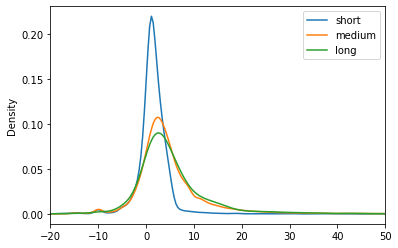

In [233]:
r1_s['pff_GAINLOSSNET'].plot.density()
r1_m['pff_GAINLOSSNET'].plot.density()
r1_l['pff_GAINLOSSNET'].plot.density()
plt.xlim(-20, 50)
plt.legend(labels=['short', 'medium', 'long'])
plt.show()

In [234]:
from sklearn.mixture import GaussianMixture

def plot_mixture(gm):
    """
    @param gm – fitted Guassian Mixture model
    
    Visualize the probability density function of a Guassian Mixture model
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    x = np.linspace(-25, 50, 1000).reshape(1000, 1)
    logprob = gm.score_samples(x)
    pdf = np.exp(logprob)
    
    ax.plot(x, pdf, '-k')
    plt.show()
    

def mixture_model(x, plot=True):
    """
    @param x — input feature (yards gained)
    @param plot — control output of function
    
    Fit a Guassian Mixture model with 2 components for yards gained input
        n_components=2 selected after experimentation
    """
    x = np.array(x['pff_GAINLOSSNET'])
    
    gm = GaussianMixture(
        n_components=2
    ).fit(x.reshape(-1, 1))
    
    if plot:
        plot_mixture(gm)
    
    return gm

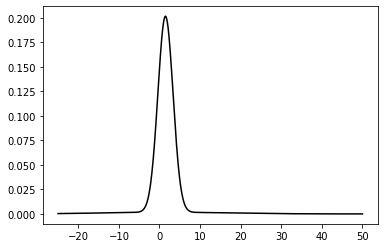

In [235]:
m = mixture_model(r1_s)

In [236]:
vals = [
    r1_s, r1_m, r1_l,
    r2_s, r2_m, r2_l,
    r3_s, r3_m, r3_l,
    r4_s, r4_m, r4_l
]
run_mixture_dict = {1: [], 2: [], 3: [], 4:[]}
run_bins = {1: [], 2: [], 3: [], 4:[]}

for i, v in enumerate(vals):
    down = i // 3 + 1
    
    m = mixture_model(v, plot=False)  
    run_mixture_dict[down].append(m)
    run_bins[down].append((min(v['pff_DISTANCE']), max(v['pff_DISTANCE']) + 1))

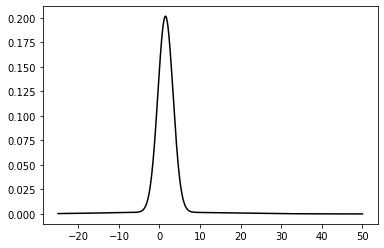

In [237]:
plot_mixture(run_mixture_dict[1][0])

In [238]:
run_mixture_dict[1][0].sample(1)[0][0][0]

4.7613221292073025

### 7.0 Pass Models <a class="anchor" id="pass"></a>

[Table of Contents](#toc)

In [239]:
p1 = PASS.loc[PASS['pff_DOWN'] == 1]
p2 = PASS.loc[PASS['pff_DOWN'] == 2]
p3 = PASS.loc[PASS['pff_DOWN'] == 3]
p4 = PASS.loc[PASS['pff_DOWN'] == 4]

In [240]:
print("Passing Downs:")
print("\t1st:", p1.shape)
print("\t2nd:", p2.shape)
print("\t3rd:", p3.shape)
print("\t4th:", p4.shape)

Passing Downs:
	1st: (113959, 6)
	2nd: (96801, 6)
	3rd: (85140, 6)
	4th: (6978, 6)


#### 7.1 Quantile Cut by Yards to Go <a class="anchor" id="cut2"></a>

In [241]:
p1['group'] = pd.qcut(p1['pff_DISTANCE'], q=[0, 0.05, 0.9675, 1], labels=['short', 'medium', 'long'])
p2['group'] = pd.qcut(p2['pff_DISTANCE'], q=[0, 0.25, 0.75, 1], labels=['short', 'medium', 'long'])
p3['group'] = pd.qcut(p3['pff_DISTANCE'], q=[0, 0.25, 0.75, 1], labels=['short', 'medium', 'long'])
p4['group'] = pd.qcut(p4['pff_DISTANCE'], q=[0, 0.5, 0.75, 1], labels=['short', 'medium', 'long'])

In [242]:
p1_s, p1_m, p1_l = p1.loc[p1['group'] == 'short'], p1.loc[p1['group'] == 'medium'], p1.loc[p1['group'] == 'long']
p2_s, p2_m, p2_l = p2.loc[p2['group'] == 'short'], p2.loc[p2['group'] == 'medium'], p2.loc[p2['group'] == 'long']
p3_s, p3_m, p3_l = p3.loc[p3['group'] == 'short'], p3.loc[p3['group'] == 'medium'], p3.loc[p3['group'] == 'long']
p4_s, p4_m, p4_l = p4.loc[p4['group'] == 'short'], p4.loc[p4['group'] == 'medium'], p4.loc[p4['group'] == 'long']

In [243]:
print("Passing Categories:")
print("\t1st:", p1.shape)
print("\t\t1st Short:", p1_s.shape)
print("\t\t1st Medium:", p1_m.shape)
print("\t\t1st Long:", p1_l.shape)
print("\t2nd:", p2.shape)
print("\t\t2nd Short:", p2_s.shape)
print("\t\t2nd Medium:", p2_m.shape)
print("\t\t2nd Long:", p2_l.shape)
print("\t3rd:", p3.shape)
print("\t\t3rd Short:", p3_s.shape)
print("\t\t3rd Medium:", p3_m.shape)
print("\t\t3rd Long:", p3_l.shape)
print("\t4th:", p4.shape)
print("\t\t4th Short:", p4_s.shape)
print("\t\t4th Medium:", p4_m.shape)
print("\t\t4th Long:", p4_l.shape)

Passing Categories:
	1st: (113959, 7)
		1st Short: (109455, 7)
		1st Medium: (2447, 7)
		1st Long: (2057, 7)
	2nd: (96801, 7)
		2nd Short: (27129, 7)
		2nd Medium: (50327, 7)
		2nd Long: (19345, 7)
	3rd: (85140, 7)
		3rd Short: (25922, 7)
		3rd Medium: (40669, 7)
		3rd Long: (18549, 7)
	4th: (6978, 7)
		4th Short: (3856, 7)
		4th Medium: (1437, 7)
		4th Long: (1685, 7)


#### 7.2 Mixture Models <a class="anchor" id="mixture2"></a>

In [244]:
vals = [
    p1_s, p1_m, p1_l,
    p2_s, p2_m, p2_l,
    p3_s, p3_m, p3_l,
    p4_s, p4_m, p4_l
]
pass_mixture_dict = {1: [], 2: [], 3: [], 4:[]}
pass_bins = {1: [], 2: [], 3: [], 4:[]}

for i, v in enumerate(vals):
    down = i // 3 + 1
    
    m = mixture_model(v, plot=False)  
    pass_mixture_dict[down].append(m)
    pass_bins[down].append((min(v['pff_DISTANCE']), max(v['pff_DISTANCE']) + 1))

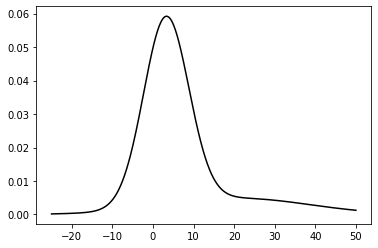

In [245]:
plot_mixture(pass_mixture_dict[1][0])

### 8.0 Expected Points Added Model <a class="anchor" id="epa"></a>

[Table of Contents](#toc)

**Hriday Completion %**

<u>Short<u>

In [310]:
s = [0.40185185185185185, 0.387123745819398, 0.3518578352180937, 0.40397350993377484]

<u>Medium<u>

In [311]:
m = [0.3900100908173562, 0.3751466944842874, 0.3601001915426551, 0.2967032967032967]

<u>Long<u>

In [312]:
l = [0.28287841191067, 0.2672672672672673, 0.22920517560073936, 0.30869565217391304]

In [313]:
completion_rates = [s, m, l]

In [315]:
def EPA(down, ytg, position, pct_run=0.5, aggression=0):
    """
    @param - down: current down of the drive (1st through 4th)
    @param - ytg: yards until next first down or endzone
    @param - position: field position (customized 1 to 100)
    @param - pct_run: likliehood the 'coach' calls a run play
    @param - aggression: scalar inclination to make 'aggressive' calls (going for conversions, etc.) 
    
    Simulate n scoring periods to calculate Expected Points Added
        Average of points scored through simulation
    """
    global reverse
    
    points = list()
    
    SIMULATIONS = 100
    for i in range(SIMULATIONS):
        reverse = False
        
        point = run_play(down, ytg, position, pct_run, aggression)
        points.append(point)
    
    return np.array(points).mean()

In [316]:
def run_play(down, ytg, position, pct_run, aggression):
    """
    @params — see above
    
    Recursive function to repeatedly simulate a play until next score;
    Dense conditional structure to determine next play given a sampled event, handling:
        4th Down Decisions (Go For It vs. Field Goal vs. Punt)
        Traditional Plays (Touchdown, Saftey, First Down)
    """
    global reverse
    
    choices = ['run', 'pass']
    choice = np.random.choice(choices, 1, p=[pct_run, 1 - pct_run])[0]

    bins = run_bins if choice == 'run' else pass_bins
    models = run_mixture_dict if choice == 'run' else pass_mixture_dict
    
    try:
        idx = [i for i, b in enumerate(bins[down]) if ytg in range(b[1])][0]
    except IndexError:
        idx = 2
    
    model = models[down][idx]
    
    if down == 4:
        # Go For It
        if aggression >= idx and position > 40:
            yards_gained = round(model.sample(1)[0][0][0], 0)
            
            # Incomplete Pass
            if choice == 'pass':
                rate = completion_rates[idx][int(down) - 1]
                yards_gained = np.random.choice([yards_gained, 0], p=[rate, 1 - rate])
            position += yards_gained
            
            # Converted
            if yards_gained >= ytg:
                down, ytg = 1, 10
                return run_play(down, ytg, position, pct_run, aggression)
            
            # Turnover on Downs
            else:
                reverse = not reverse
                down, ytg = 1, 10
                return run_play(down, ytg, 100 - position, pct_run, aggression)
                
        # Field Goal
        elif (position >= 60) or (50 >= position < 60 and AGGRESSION == 2):
            hash_ = list(np.zeros(3))
            hash_[np.random.randint(0, 3)] = 1
            hash_.extend([100 - position + 17])
            result = fg_model.predict(np.array(hash_).reshape(1, -1))[0]
            
            if result == 0:
                reverse = not reverse
                down, ytg = 1, 10
                return run_play(down, ytg, 100 - position, pct_run, aggression)
            else:
                score = True
                scored = 3
            
        # Punt
        else:
            net_yards = round(punt_model.sample(1)[0][0][0], 0)
            position += net_yards
            
            # Punt Returned for TD
            if position < 0:
                score = True
                scored = -7
            # Touchback
            elif position >= 100:
                down, ytg = 1, 10
                return run_play(down, ytg, 25, pct_run, aggression)
            else:
                reverse = not reverse
                down, ytg = 1, 10
                return run_play(down, ytg, 100 - position, pct_run, aggression)
        
    else:
        yards_gained = round(model.sample(1)[0][0][0], 0)
        
        # Incomplete Pass
        if choice == 'pass':
                rate = completion_rates[idx][int(down) - 1]
                yards_gained = np.random.choice([yards_gained, 0], p=[rate, 1 - rate])
        position += yards_gained
        
        # Touchdown
        if position >= 100:
            score = True
            scored = 7
            
        # Safety
        elif position <= 0:
            score = True
            scored = -2
            
        # First Down
        elif yards_gained >= ytg:
            down, ytg = 1, 10
            return run_play(down, ytg, position, pct_run, aggression)
        else:
            return run_play(down + 1, ytg - yards_gained, position, pct_run, aggression)
    
    return scored if not reverse else -scored

In [332]:
SEED = 42
PCT_RUN = 0.5
AGGRESSION = 0

In [345]:
down = 1
ytg = 1
position = 98

In [346]:
STATE = {
    'down': down,
    'ytg': ytg,
    'position': position,
    'pct_run': PCT_RUN,
    'aggression': AGGRESSION
}

In [347]:
%%time

epa = EPA(**STATE)

CPU times: user 154 ms, sys: 3.38 ms, total: 157 ms
Wall time: 175 ms


In [348]:
print('''
    Expected Points Model:
    S (Down: {}, YTG: {}, Position: {}) == {} EP
'''.format(
    STATE['down'],
    STATE['ytg'],
    ('Own ' if STATE['position'] < 50 else '') + 
    str(STATE['position'] if STATE['position'] < 50 else 100 - STATE['position']),
    epa
))


    Expected Points Model:
    S (Down: 1, YTG: 1, Position: 2) == 6.46 EP



### 9.0 Data Visualization <a class="anchor" id="viz"></a>

[Table of Contents](#toc)

#### 9.1 Calculate EPA for Start State Grid <a class="anchor" id="grid"></a>

In [321]:
DOWNS = [1, 2, 3, 4]
YARDS = [2, 5, 10]
POSITION = list(range(10, 100, 10))
PCT_RUN = [0.25, 0.5, 0.75]
AGGRESSION = [0, 1, 2]

In [322]:
import itertools
states = np.array(
    list(itertools.product(DOWNS, YARDS, POSITION, PCT_RUN, AGGRESSION))
)

In [323]:
states.shape

(972, 5)

In [324]:
states

array([[ 1.  ,  2.  , 10.  ,  0.25,  0.  ],
       [ 1.  ,  2.  , 10.  ,  0.25,  1.  ],
       [ 1.  ,  2.  , 10.  ,  0.25,  2.  ],
       ...,
       [ 4.  , 10.  , 90.  ,  0.75,  0.  ],
       [ 4.  , 10.  , 90.  ,  0.75,  1.  ],
       [ 4.  , 10.  , 90.  ,  0.75,  2.  ]])

In [325]:
def call_epa(inputs):
    """
    @param inputs — array of state parameters (down, ytg, position, pct_run, aggression)
    
    Helper to vectorize EPA function call
    """
    return EPA(*inputs)

**WARNING:** ~10 minute runtime

In [326]:
%%time

epa_vect = np.vectorize(call_epa, signature='(n)->()')
epa_lst = epa_vect(np.array(states))

CPU times: user 23min 3s, sys: 12.1 s, total: 23min 15s
Wall time: 25min 15s


In [327]:
states_df = pd.DataFrame(
    states, columns=['down', 'yard', 'position', 'percent_run', 'aggression']
)

In [328]:
states_df['epa'] = epa_lst

#### 9.2 Plotly EPA Bar Chart <a class="anchor" id="plotly"></a>

In [329]:
import plotly.express as px

In [330]:
states_df_sorted = states_df.sort_values(by=['position', 'epa'])
fig = px.bar(
    states_df_sorted, x="position", y='epa', color='epa'
)
fig.show()

#### 9.3 Football Field Graphic (Future Use) <a class="anchor" id="field"></a>

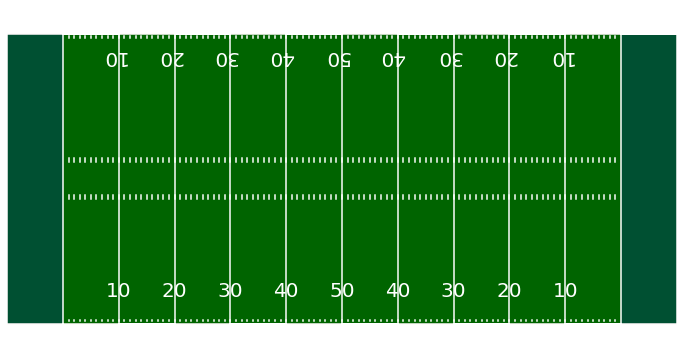

In [331]:
import matplotlib.patches as patches

def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

create_football_field()
plt.show()

### 10.0 References <a class="anchor" id="ref"></a>

[Table of Contents](#toc)

* [Pro Football Focus](https://pff.com)
* [sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture)  
* [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
* [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
* [Football Field Graphic – Kaggle](https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position)
* [Plotly Bar Viz](https://plotly.com/python/bar-charts/)

### 11.0 Authors <a class="anchor" id="authors"></a>

[Table of Contents](#toc)

**Iain Muir**
* E – iam9ez@virginia.edu  
* [LinkedIn](https://www.linkedin.com/in/iain-a-muir/)

**Hriday Singh**  
* E – hns4dc@virginia.edu  
* [LinkedIn](https://www.linkedin.com/in/hriday-singh-b60b86182/)

**Connor Smith**  
* E – cms6xs@virginia.edu  
* [LinkedIn](https://www.linkedin.com/in/connor-smith-5b5b08176/)